In [1]:
#%%

import os
import logging
# 配置 logging
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# os.chdir(os.path.dirname(__file__))
import numpy as np
import nonlincausality as nlc
import matplotlib.pyplot as plt
import copy
from nonlincausality.utils import prepare_data_for_prediction, calculate_pred_and_errors
from sklearn.svm import SVR
import pandas as pd

2024-12-13 15:10:34,337 - matplotlib - DEBUG - matplotlib data path: /root/miniconda3/envs/cs0/lib/python3.9/site-packages/matplotlib/mpl-data
2024-12-13 15:10:34,344 - matplotlib - DEBUG - CONFIGDIR=/root/.config/matplotlib
2024-12-13 15:10:34,353 - matplotlib - DEBUG - interactive is False
2024-12-13 15:10:34,353 - matplotlib - DEBUG - platform is linux
2024-12-13 15:10:34,403 - matplotlib - DEBUG - CACHEDIR=/root/.cache/matplotlib
2024-12-13 15:10:34,405 - matplotlib.font_manager - DEBUG - Using fontManager instance from /root/.cache/matplotlib/fontlist-v390.json
2024-12-13 15:10:35.127362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-13 15:10:35.167690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempt

In [2]:
#%% Data generation Y->X
# 读取数据
emission_data = pd.read_csv('dataset/total_monthly_state_emission.csv')
vehicle_data = pd.read_csv('dataset/result_anhui.csv')
# 数据日期清洗和准备
# 首先，你需要确保日期列是字符串类型
emission_data['date'] = emission_data['date'].astype(str)
vehicle_data['date'] = vehicle_data['date'].astype(str)
# 使用pd.to_datetime将日期字符串转换为日期时间对象
# format参数指定了原始日期字符串的格式Jan-19
emission_data['date'] = pd.to_datetime(emission_data['date'], format='%b-%y')
vehicle_data['date'] = pd.to_datetime(vehicle_data['date'], format='%Y/%m/%d')
# 将日期时间对象转换回字符串，格式为'YYYY-MM-DD'
emission_data['date'] = emission_data['date'].dt.strftime('%Y-%m-%d')
vehicle_data['date'] = vehicle_data['date'].dt.strftime('%Y-%m-%d')
# 选取时间范围
start_date = '2022-06-01'
end_date = '2024-09-01'
vehicle_data_mask = (vehicle_data['date'] >= start_date) & (vehicle_data['date'] <= end_date)
emission_data_mask = (emission_data['date'] >= start_date) & (emission_data['date'] <= end_date)

emission_data = emission_data.loc[emission_data_mask]
vehicle_data = vehicle_data.loc[vehicle_data_mask]
# 丢掉第一列
emission_data=emission_data.drop(emission_data.columns[[0]],axis=1)
# 数据对齐
emission_data.set_index('date', inplace=True)
vehicle_data.set_index('date', inplace=True)

# logging.debug(emission_data)
# logging.debug(vehicle_data)
# Merge Data by Date
# Group vehicle_data by date and sum the values for all cities
vehicle_data_grouped = vehicle_data.groupby('date').sum()

# Merge the emission_data and vehicle_data_grouped datasets on the date column
merged_data = pd.merge(emission_data, vehicle_data_grouped, on='date', how='inner')

# Display the merged data
merged_data=merged_data.drop(merged_data.columns[[1]],axis=1)
merged_data

,Anhui,EVER,PHEV,FUEL,EV
date,,,,,
2022-06-01,34.809514,511,46716,102753,56160
2022-07-01,38.540280,578,34296,66654,35271
2022-08-01,41.149139,736,51952,97491,52199
2022-09-01,33.011258,675,50984,95619,55048
2022-10-01,33.251411,647,46008,105528,56757
2022-11-01,32.326106,1144,49481,101568,51796
2022-12-01,36.015482,1147,45684,103977,55845
2023-01-01,32.817612,872,50317,100269,53213
2023-02-01,30.508653,800,45520,107466,56993


2024-12-13 15:10:37,051 - root - DEBUG - [[-0.27567927 -1.19719411 -0.45502008  0.2872498   0.76909223]
 [ 0.98856048 -1.12678639 -3.91354264 -4.77983672 -4.62035847]
 [ 1.87262097 -0.96075025  1.00301729 -0.45135817 -0.25286259]
 [-0.88505169 -1.02485281  0.73346416 -0.71412406  0.48219151]
 [-0.80367132 -1.05427693 -0.65217257  0.67676655  0.92312076]
 [-1.11722834 -0.5319987   0.31493281  0.12091562 -0.3568383 ]
 [ 0.13298555 -0.52884612 -0.7423949   0.45905827  0.68782089]
 [-0.95067236 -0.81783307  0.54772869 -0.06142032  0.00875372]
 [-1.73310614 -0.8934951  -0.78806299  0.94879663  0.98400977]
 [-0.08273019 -0.81047703  0.2778971  -0.06268362  0.04048824]
 [-1.11035813 -0.6717633  -0.96405222  1.00648722 -0.51396289]
 [-0.27014997 -0.38172549 -0.53104074  0.47590224 -0.24409045]
 [ 0.23146404 -0.43952288 -0.87522222  0.32009554 -0.37102853]
 [ 1.56819573 -0.33969102  0.3026804  -0.3330293   0.55236866]
 [ 1.45786369  0.01444935  0.38789037 -0.0222581  -0.09238395]
 [-0.14652624 

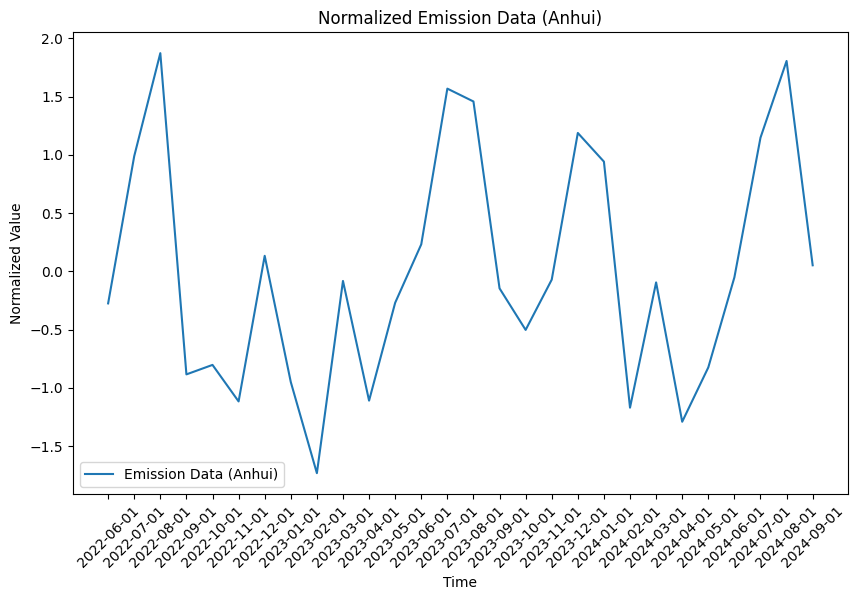

2024-12-13 15:10:37,311 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-13 15:10:37,314 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-13 15:10:37,316 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-13 15:10:37,317 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-13 15:10:37,

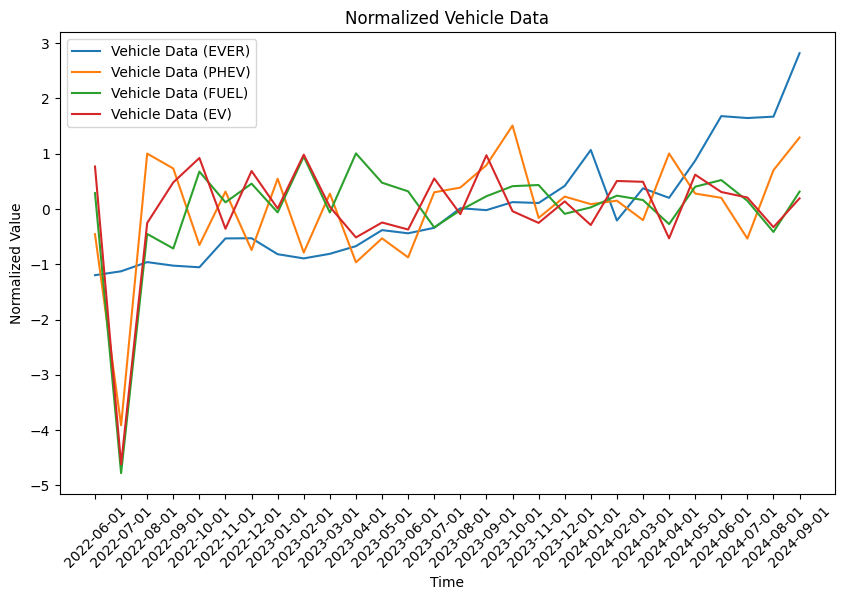

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# 创建归一化器
scaler = StandardScaler()

# 归一化数据
'''
FIXME: 一起做归一化之后出现大量极值
'''
merged_data_n = scaler.fit_transform(merged_data)
# emission_data_n = scaler.fit_transform(merged_data.iloc[:, [0]])
# vehicle_data_n = scaler.fit_transform(merged_data.iloc[:, 1:])
logging.debug(merged_data_n)
# logging.debug(emission_data_n)
# logging.debug(vehicle_data_n)

# 绘制图形
plt.figure(figsize=(10, 6))
# 绘制 emission_data
plt.plot(merged_data.index, merged_data_n[:, 0], label='Emission Data (Anhui)')
# 添加标题和标签
plt.title('Normalized Emission Data (Anhui)')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
# 旋转 x 轴标签
plt.xticks(rotation=45)
# 显示图形
plt.show()

# 绘制图形
plt.figure(figsize=(10, 6))
# 绘制 vehicle_data
plt.plot(merged_data.index, merged_data_n[:, 1], label='Vehicle Data (EVER)')
plt.plot(merged_data.index, merged_data_n[:, 2], label='Vehicle Data (PHEV)')
plt.plot(merged_data.index, merged_data_n[:, 3], label='Vehicle Data (FUEL)')
plt.plot(merged_data.index, merged_data_n[:, 4], label='Vehicle Data (EV)')
# 添加标题和标签
plt.title('Normalized Vehicle Data')
plt.xlabel('Time')
plt.ylabel('Normalized Value')
plt.legend()
# 旋转 x 轴标签
plt.xticks(rotation=45)
# 显示图形
plt.show()


# tune parameter

2024-12-13 15:43:33,091 - root - DEBUG - [[-1.19719411 -0.27567927]
 [-1.12678639  0.98856048]
 [-0.96075025  1.87262097]
 [-1.02485281 -0.88505169]
 [-1.05427693 -0.80367132]
 [-0.5319987  -1.11722834]
 [-0.52884612  0.13298555]
 [-0.81783307 -0.95067236]
 [-0.8934951  -1.73310614]
 [-0.81047703 -0.08273019]
 [-0.6717633  -1.11035813]
 [-0.38172549 -0.27014997]
 [-0.43952288  0.23146404]
 [-0.33969102  1.56819573]
 [ 0.01444935  1.45786369]
 [-0.02022909 -0.14652624]]
2024-12-13 15:43:33,096 - tensorflow - DEBUG - Layer gru_32 will use cuDNN kernels when running on GPU.
2024-12-13 15:43:33,257 - tensorflow - DEBUG - Layer gru_33 will use cuDNN kernels when running on GPU.


Epoch 1/123
3/3 [==============================] - 1s 174ms/step - loss: 0.1415 - mse: 0.1415 - val_loss: 0.0658 - val_mse: 0.0658
Epoch 2/123
3/3 [==============================] - 0s 41ms/step - loss: 0.1818 - mse: 0.1818 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 3/123
3/3 [==============================] - 0s 35ms/step - loss: 0.1038 - mse: 0.1038 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 4/123
3/3 [==============================] - 0s 39ms/step - loss: 0.1054 - mse: 0.1054 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 5/123
3/3 [==============================] - 0s 34ms/step - loss: 0.0602 - mse: 0.0602 - val_loss: 0.0949 - val_mse: 0.0949
Epoch 6/123
3/3 [==============================] - 0s 33ms/step - loss: 0.0819 - mse: 0.0819 - val_loss: 0.1100 - val_mse: 0.1100
Epoch 7/123
3/3 [==============================] - 0s 33ms/step - loss: 0.0646 - mse: 0.0646 - val_loss: 0.1315 - val_mse: 0.1315
Epoch 8/123
3/3 [==============================] - 0s 32ms/step - loss: 0.0660 - mse: 0.0

2024-12-13 15:44:04,724 - tensorflow - DEBUG - Layer gru_34 will use cuDNN kernels when running on GPU.
2024-12-13 15:44:04,872 - tensorflow - DEBUG - Layer gru_35 will use cuDNN kernels when running on GPU.


Epoch 1/123
3/3 [==============================] - 1s 183ms/step - loss: 0.2195 - mse: 0.2195 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 2/123
3/3 [==============================] - 0s 42ms/step - loss: 0.0775 - mse: 0.0775 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 3/123
3/3 [==============================] - 0s 34ms/step - loss: 0.0628 - mse: 0.0628 - val_loss: 0.0689 - val_mse: 0.0689
Epoch 4/123
3/3 [==============================] - 0s 38ms/step - loss: 0.0613 - mse: 0.0613 - val_loss: 0.0834 - val_mse: 0.0834
Epoch 5/123
3/3 [==============================] - 0s 36ms/step - loss: 0.0635 - mse: 0.0635 - val_loss: 0.1155 - val_mse: 0.1155
Epoch 6/123
3/3 [==============================] - 0s 37ms/step - loss: 0.0764 - mse: 0.0764 - val_loss: 0.1662 - val_mse: 0.1662
Epoch 7/123
3/3 [==============================] - 0s 36ms/step - loss: 0.0548 - mse: 0.0548 - val_loss: 0.2235 - val_mse: 0.2235
Epoch 8/123
3/3 [==============================] - 0s 39ms/step - loss: 0.0659 - mse: 0.0

2024-12-13 15:44:35,921 - tensorflow - DEBUG - Layer gru_36 will use cuDNN kernels when running on GPU.
2024-12-13 15:44:36,083 - tensorflow - DEBUG - Layer gru_37 will use cuDNN kernels when running on GPU.


Epoch 1/123
3/3 [==============================] - 1s 181ms/step - loss: 0.4485 - mse: 0.4485 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 2/123
3/3 [==============================] - 0s 35ms/step - loss: 0.0981 - mse: 0.0981 - val_loss: 0.0548 - val_mse: 0.0548
Epoch 3/123
3/3 [==============================] - 0s 33ms/step - loss: 0.1712 - mse: 0.1712 - val_loss: 0.0777 - val_mse: 0.0777
Epoch 4/123
3/3 [==============================] - 0s 34ms/step - loss: 0.1062 - mse: 0.1062 - val_loss: 0.1000 - val_mse: 0.1000
Epoch 5/123
3/3 [==============================] - 0s 33ms/step - loss: 0.0609 - mse: 0.0609 - val_loss: 0.1157 - val_mse: 0.1157
Epoch 6/123
3/3 [==============================] - 0s 32ms/step - loss: 0.0796 - mse: 0.0796 - val_loss: 0.1213 - val_mse: 0.1213
Epoch 7/123
3/3 [==============================] - 0s 33ms/step - loss: 0.0610 - mse: 0.0610 - val_loss: 0.1443 - val_mse: 0.1443
Epoch 8/123
3/3 [==============================] - 0s 33ms/step - loss: 0.0755 - mse: 0.0

2024-12-13 15:45:05,537 - tensorflow - DEBUG - Layer gru_38 will use cuDNN kernels when running on GPU.
2024-12-13 15:45:05,692 - tensorflow - DEBUG - Layer gru_39 will use cuDNN kernels when running on GPU.


Epoch 1/123
3/3 [==============================] - 1s 189ms/step - loss: 0.2767 - mse: 0.2767 - val_loss: 0.0661 - val_mse: 0.0661
Epoch 2/123
3/3 [==============================] - 0s 51ms/step - loss: 0.1168 - mse: 0.1168 - val_loss: 0.0615 - val_mse: 0.0615
Epoch 3/123
3/3 [==============================] - 0s 35ms/step - loss: 0.1704 - mse: 0.1704 - val_loss: 0.0827 - val_mse: 0.0827
Epoch 4/123
3/3 [==============================] - 0s 40ms/step - loss: 0.0971 - mse: 0.0971 - val_loss: 0.1048 - val_mse: 0.1048
Epoch 5/123
3/3 [==============================] - 0s 38ms/step - loss: 0.1181 - mse: 0.1181 - val_loss: 0.1058 - val_mse: 0.1058
Epoch 6/123
3/3 [==============================] - 0s 41ms/step - loss: 0.0815 - mse: 0.0815 - val_loss: 0.0991 - val_mse: 0.0991
Epoch 7/123
3/3 [==============================] - 0s 43ms/step - loss: 0.0908 - mse: 0.0908 - val_loss: 0.1128 - val_mse: 0.1128
Epoch 8/123
3/3 [==============================] - 0s 46ms/step - loss: 0.0830 - mse: 0.0

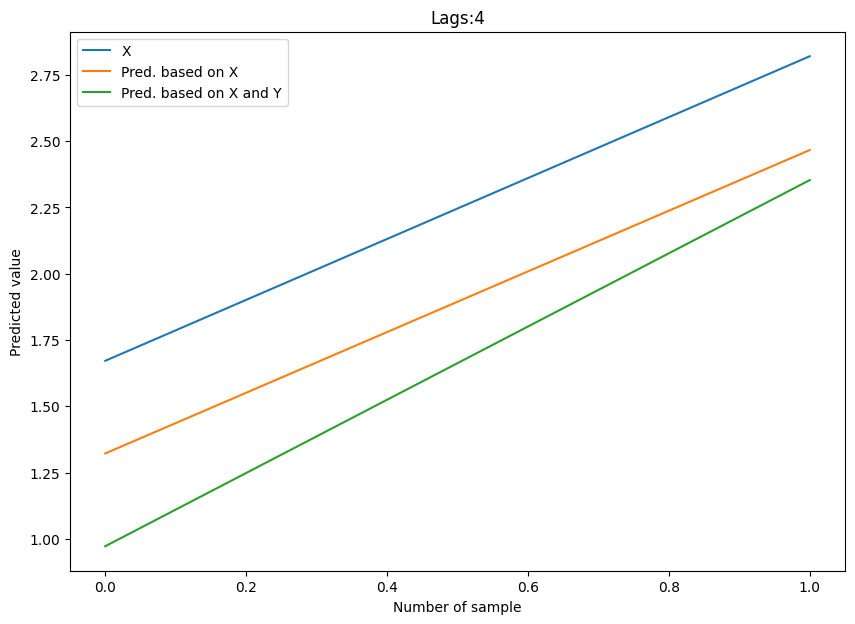

In [8]:
#%% Test in case of presence of the causality

lags = [4]
# 60%-train, 20%-validation, 20%-test
# switch emission and vehicle data, X is vehicle data, Y is emission data
data_train = merged_data_n[:16, [1, 0]]
data_val = merged_data_n[16:22, [1, 0]]
data_test = merged_data_n[22:, [1, 0]]
logging.debug(data_train)

# results = nlc.nonlincausalityNN(
#     x=data_train,
#     maxlag=lags,
#     NN_config=['l', 'dr','d','dr'],
#     NN_neurons=[100,0.05,100,0.05],
#     x_test=data_test,
#     run=3,
#     epochs_num=[100],
#     learning_rate=[0.001],
#     batch_size_num=16, #32,
#     x_val=data_val,
#     reg_alpha=0.001,
#     callbacks=None,
#     verbose=True,
#     plot=True,
# )
# results = nlc.nonlincausalityNN(
#     x=data_train,
#     maxlag=lags,
#     NN_config=['l', 'dr', 'd', 'dr'],  # 保持简单的网络结构
#     NN_neurons=[64, 0.2, 32, 0.2],  # 减小网络规模，增加dropout率
#     x_test=data_test,
#     run=3,
#     epochs_num=[150, 100],  # 增加训练轮数
#     learning_rate=[0.005, 0.0005],  # 略微提高学习率
#     batch_size_num=4,  # 使用较小的batch size
#     x_val=data_val,
#     reg_alpha=0.005,  # 适当调整正则化强度
#     callbacks=None,
#     verbose=True,
#     plot=True,
# )
# results = nlc.nonlincausalityNN(
#     x=data_train,
#     maxlag=lags,
#     NN_config=['l', 'dr', 'd'],  # 简化网络结构
#     NN_neurons=[128, 0.1, 64],  # 增大神经元数量，降低dropout
#     x_test=data_test,
#     run=3,
#     epochs_num=[300, 200],  # 大幅增加训练轮数
#     learning_rate=[0.003, 0.0003],  # 调整学习率
#     batch_size_num=8,  # 增加batch size提高稳定性
#     x_val=data_val,
#     reg_alpha=0.0001,  # 显著降低正则化强度
#     callbacks=None,
#     verbose=True,
#     plot=True,
# )
# results = nlc.nonlincausalityNN(
#     x=data_train,
#     maxlag=lags,
#     NN_config=['g', 'l', 'd'],  # 使用GRU和LSTM的组合
#     NN_neurons=[256, 128, 64],  # 增大网络容量
#     x_test=data_test,
#     run=5,  # 增加运行次数提高稳定性
#     epochs_num=[400, 300],  # 进一步增加训练轮数
#     learning_rate=[0.01, 0.001],  # 提高初始学习率
#     batch_size_num=4,  # 减小batch size
#     x_val=data_val,
#     reg_alpha=0,  # 移除L2正则化
#     callbacks=None,
#     verbose=True,
#     plot=True,
# )
results = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['g', 'dr'],  # 使用GRU和LSTM的组合
    NN_neurons=[181, 0.10039621206592916],  # 增大网络容量
    x_test=data_test,
    run=4,  # 增加运行次数提高稳定性
    epochs_num=[123, 34],  # 进一步增加训练轮数
    learning_rate=[0.00869299151113955, 0.0003550304858128307],  # 提高初始学习率
    batch_size_num=4,  # 减小batch size
    x_val=data_val,
    reg_alpha=0.004835952776465951,  # L2正则化
    callbacks=None,
    verbose=True,
    plot=True,
)


For lag = 4 Cohen's d = 1.631
Test statistic = 0.0 p-value = 1.0
1/1 [==============================] - 0s 26ms/step


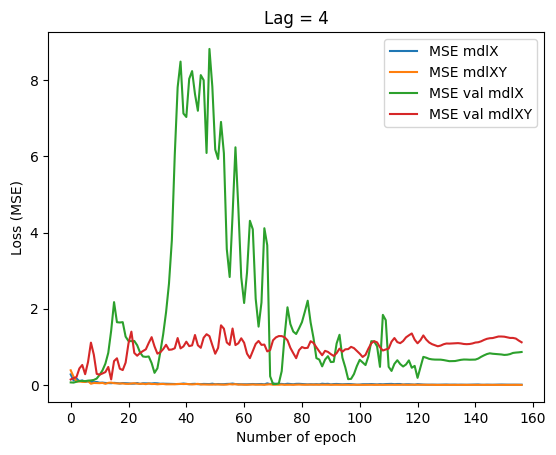

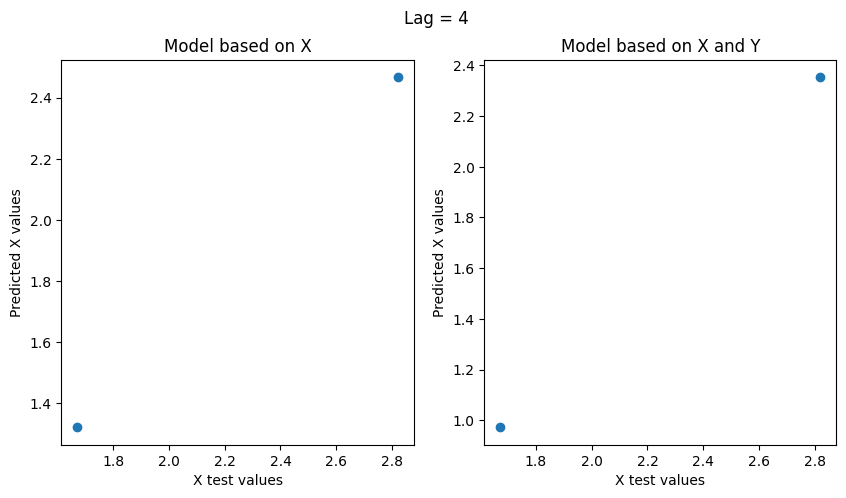

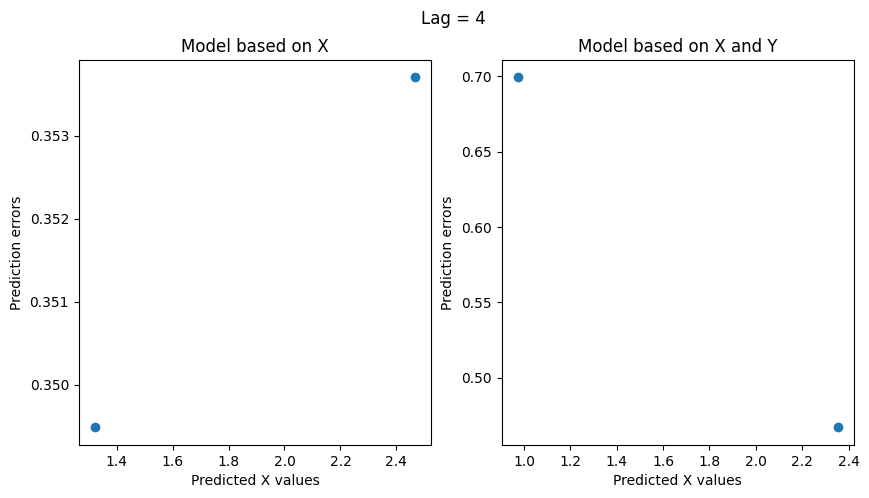

In [9]:
#%% Example of obtaining the results

for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

# RUN ME

In [ ]:
'''
run!!!!!
'''
logging.debug("run!!!!")

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

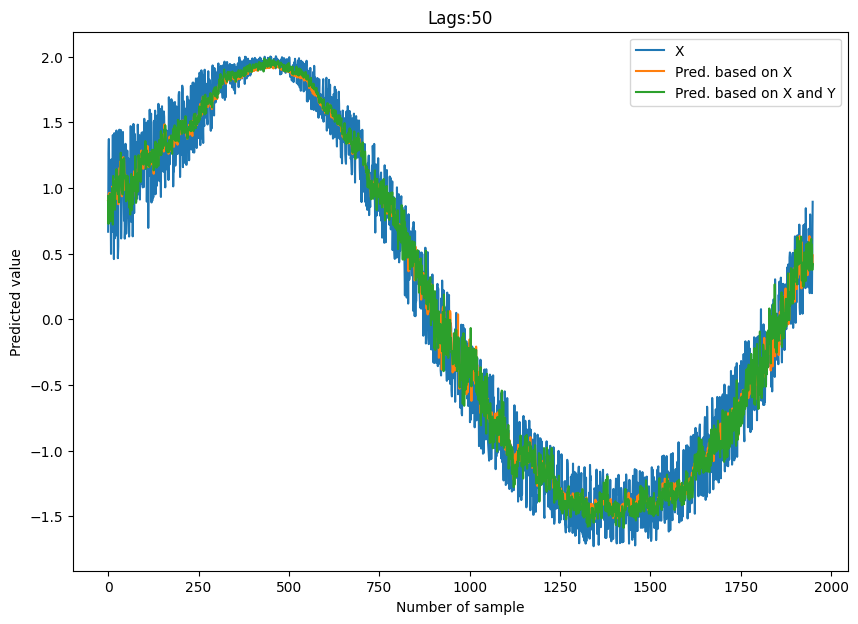

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.1167 - mse: 0.1167 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

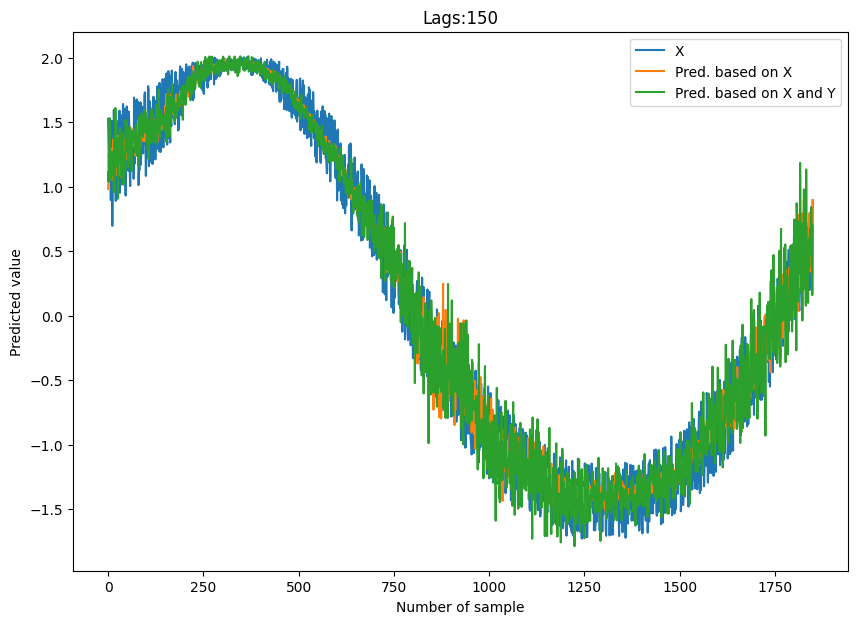

In [ ]:
#%% Test in case of absence of the causality

np.random.seed(30)
data_noise = np.vstack([x[:-100], np.random.random(10_000)]).T

lags = [50, 150]
data_noise_train = data_noise[:6000, :]
data_noise_val = data_noise[6000:8000, :]
data_noise_test = data_noise[8000:, :]

results = nlc.nonlincausalityNN(
    x=data_noise_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_noise_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.001, 0.0001],
    batch_size_num=32,
    x_val=data_noise_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

For lag = 50 Cohen's d = 0.029
test statistic = 886494.0 p-value = 0.995318875558966
For lag = 150 Cohen's d = 0.113
test statistic = 676264.5 p-value = 0.9999999999999974


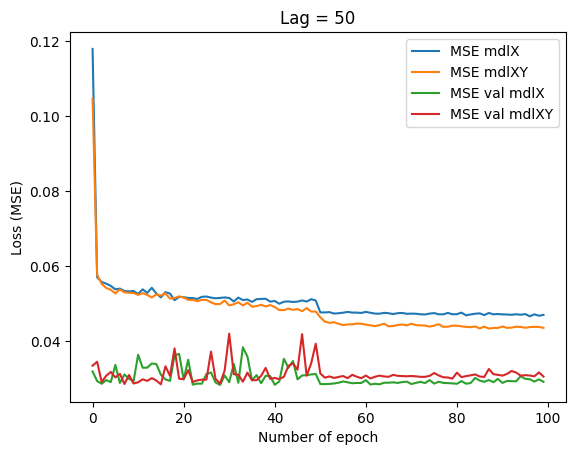

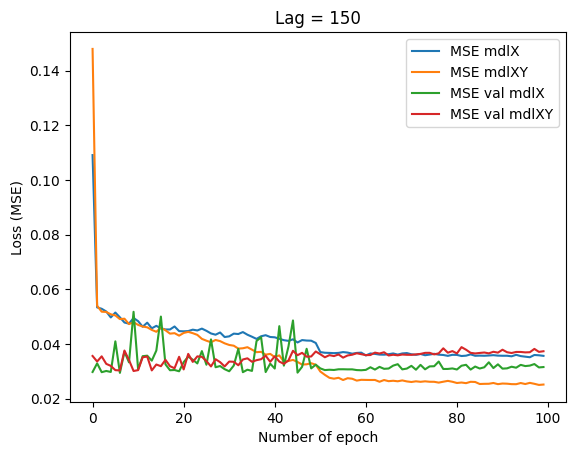

In [ ]:
#%% Example of obtaining the results

for lag in lags:
    best_model_X_lag50 = results[lag].best_model_X
    best_model_XY_lag50 = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag].test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"test statistic = {test_statistic} p-value = {p_value}")

0->1
Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3388 - mse: 0.3388 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0631 - mse: 0.0631 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0604 - mse: 0.0604 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - los

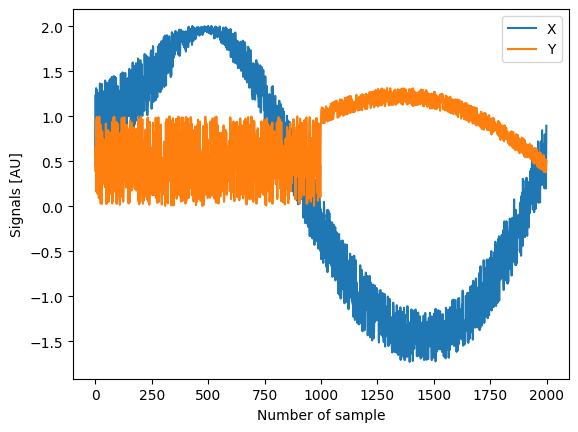

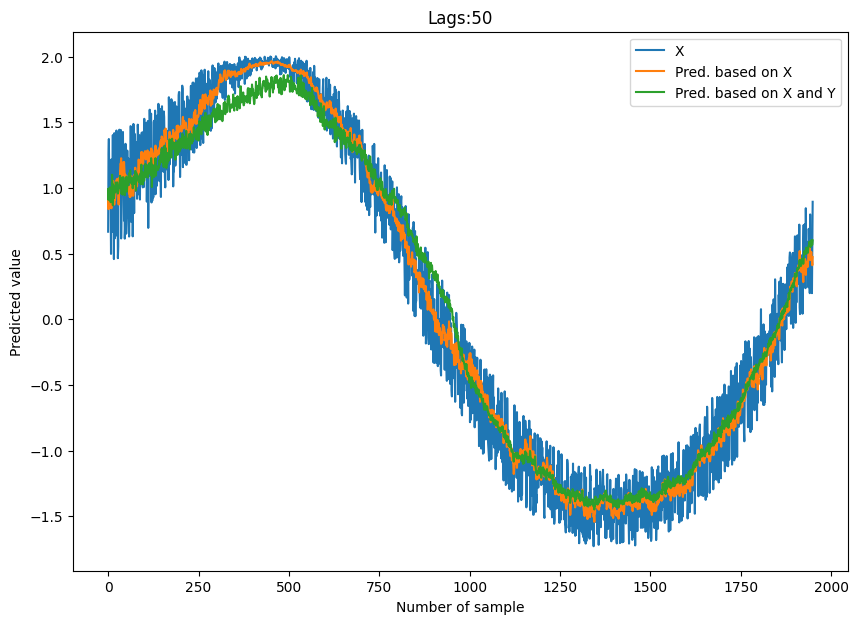

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.2324 - mse: 0.2324 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

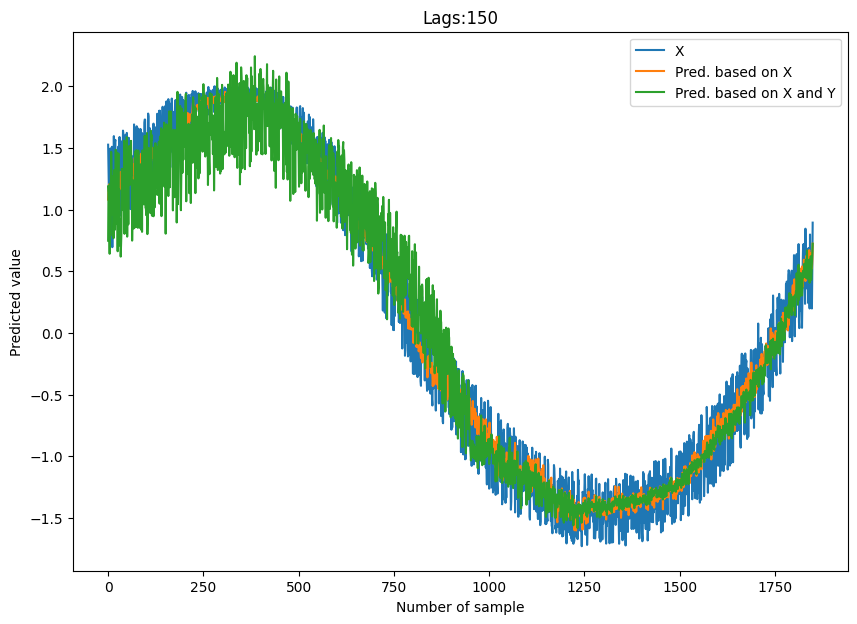

58/58 [==============================] - 0s 2ms/step
1->0
Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
186/186

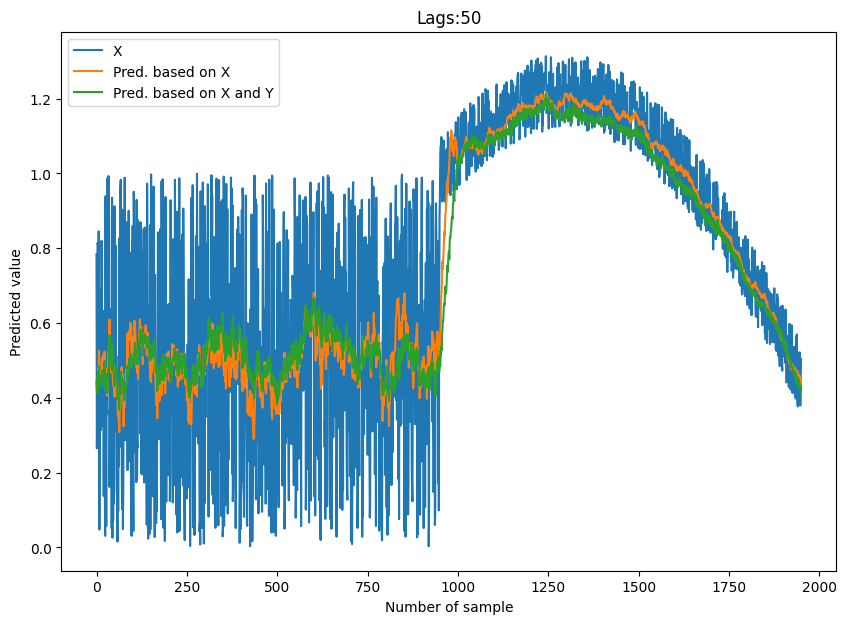

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

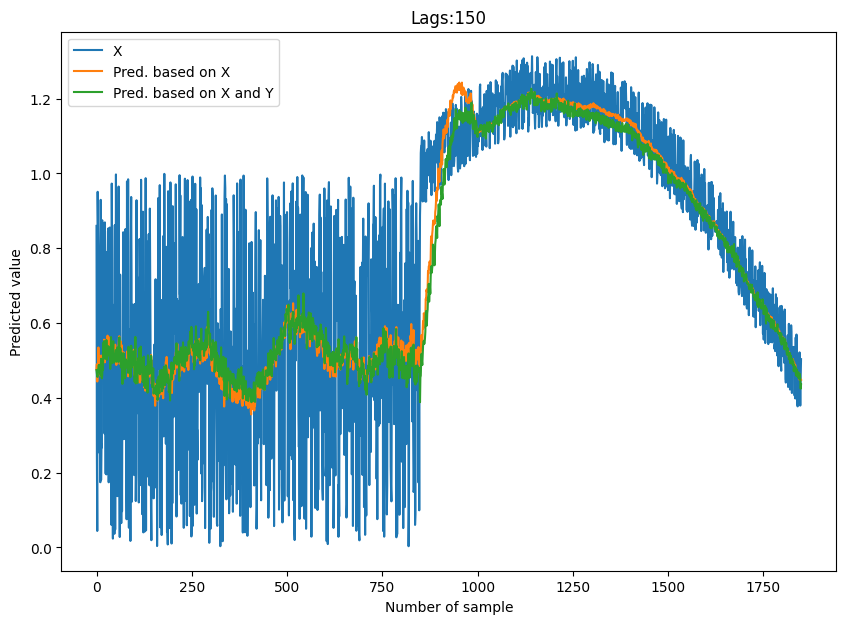

58/58 [==============================] - 0s 2ms/step


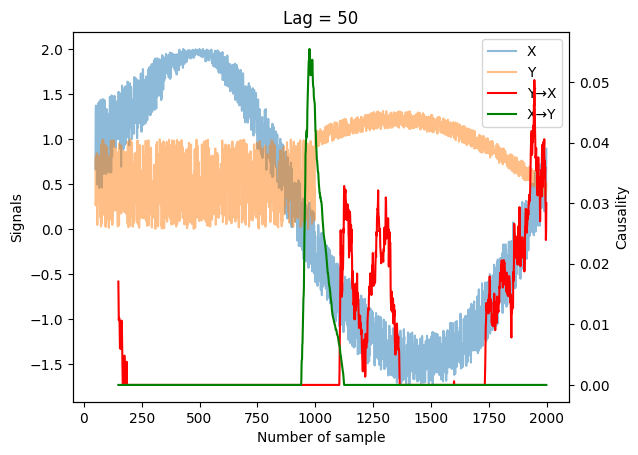

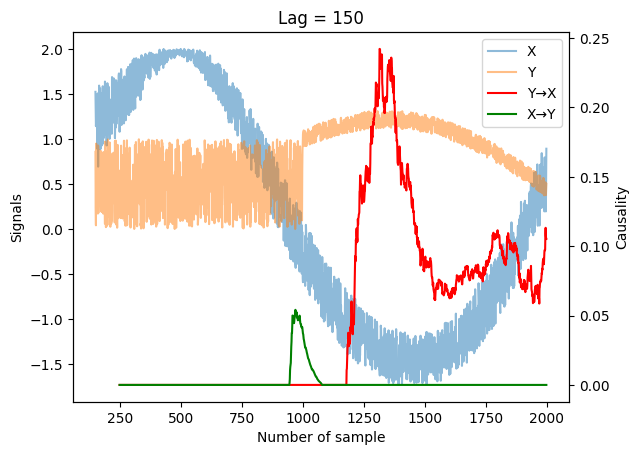

In [ ]:
#%% Example of the measure of the causality change over time

data_test_measure = copy.copy(data_test)
np.random.seed(30)
data_test_measure[:1000, 1] = np.random.random(1000)

plt.figure()
plt.plot(data_test_measure[:, 0], label="X")
plt.plot(data_test_measure[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

results = nlc.nonlincausalitymeasureNN(
    x=data_train,
    maxlag=lags,
    window=100,
    step=1,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test_measure,
    run=3,
    epochs_num=[50,50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    verbose=True,
    plot=True,
)

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3035 - mse: 0.3035 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

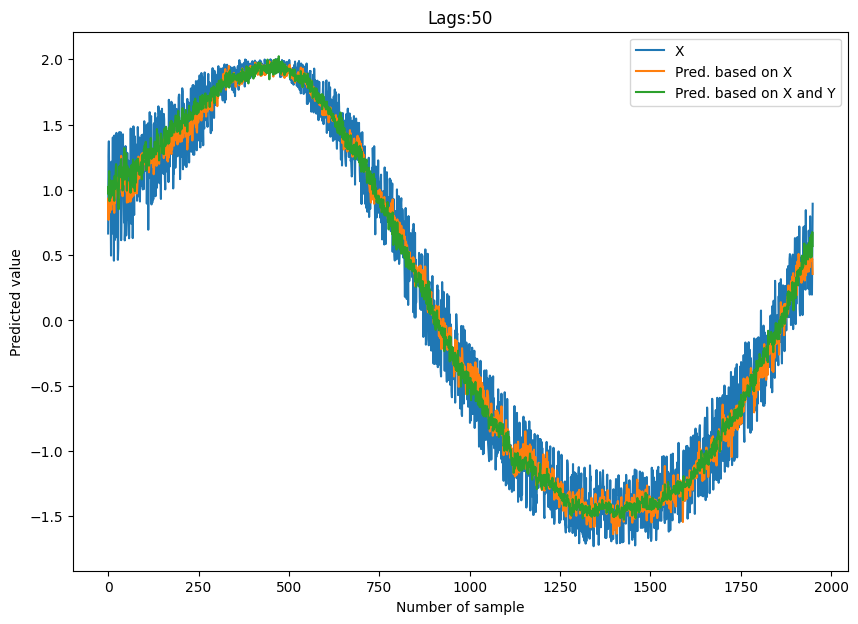

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0676 - mse: 0.0676 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

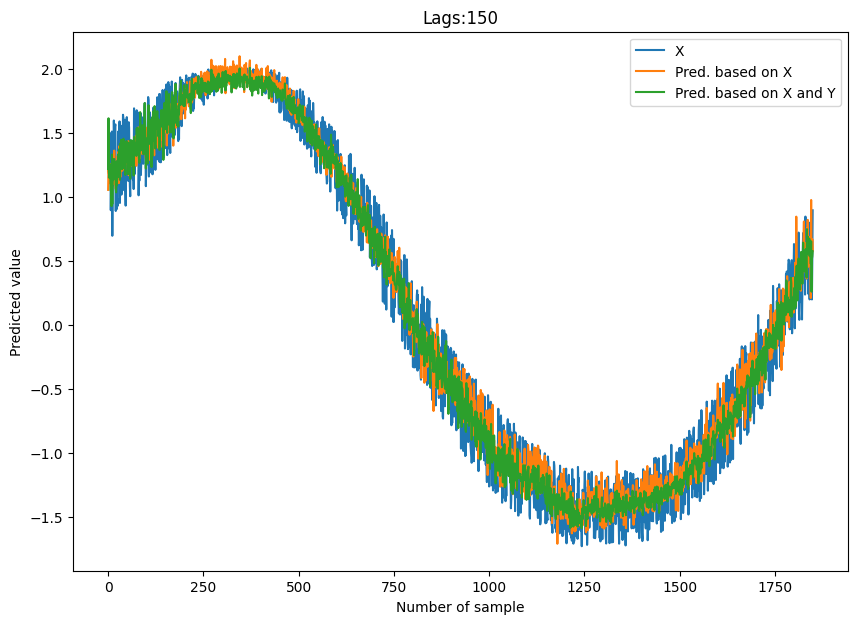

In [ ]:
#%% Example of usage for conditional analysis

np.random.seed(30)
z = np.random.random([10_000, 2])

z_train = z[:6000, :]
z_val = z[6000:8000, :]
z_test = z[8000:, :]

results_conditional = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=1,
    z=z_train,
    z_test=z_test,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    z_val=z_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

Statistics value = 1042424.0 p-value = 0.00012035170468659112


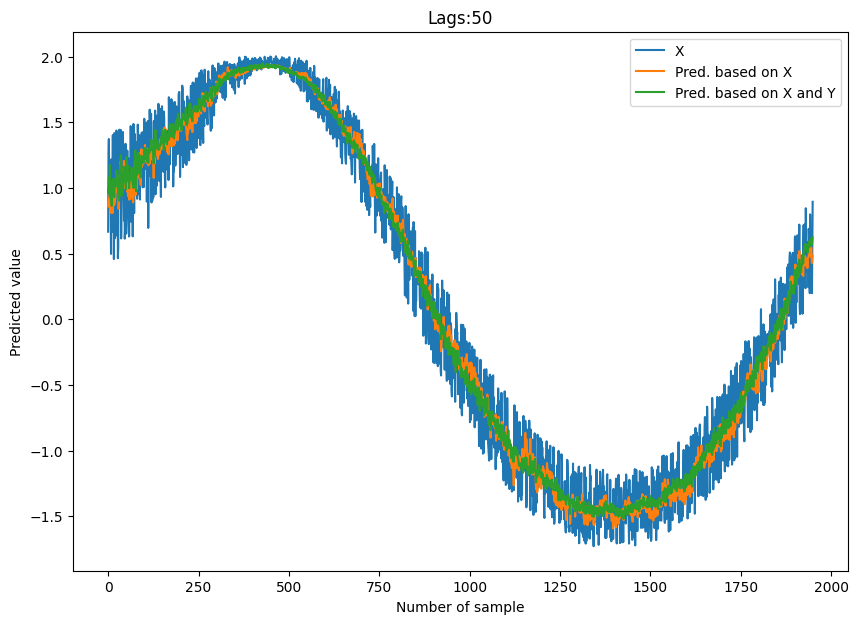

Statistics value = 1099413.0 p-value = 1.6802747241548963e-26


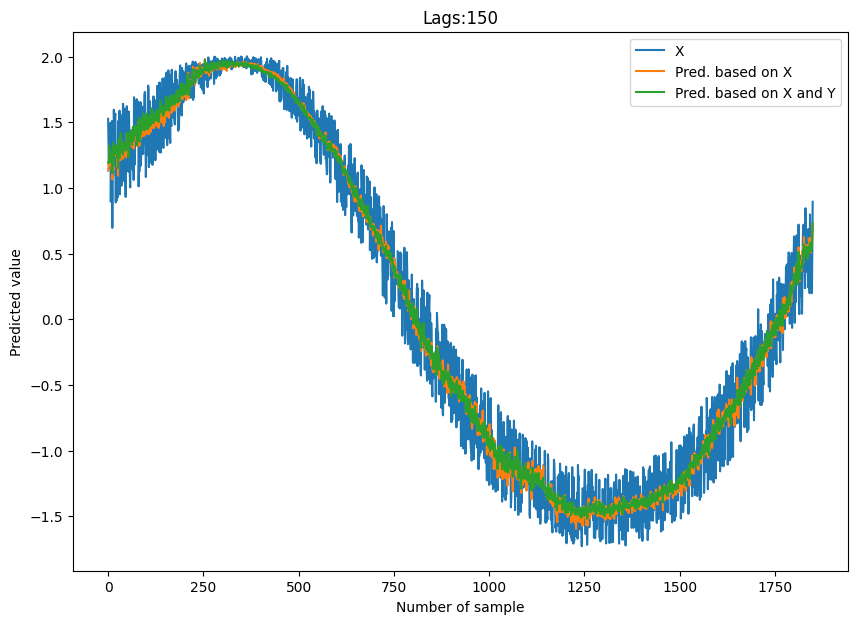

In [ ]:
# %% Exaple of the usage the package with Scikit-learn model

parametres = {
    'kernel':['poly', 'rbf'],
    'C':[0.01,0.1,1], 
    'epsilon':[0.01,0.1,1.]
}
results_skl = nlc.nonlincausality_sklearn(    
    x=data_train,
    sklearn_model=SVR,
    maxlag=lags,
    params=parametres,
    x_test=data_test,
    x_val=data_val,
    plot=True)

/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statistics value = 9449.0 p-value = 0.3566899541578241


/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


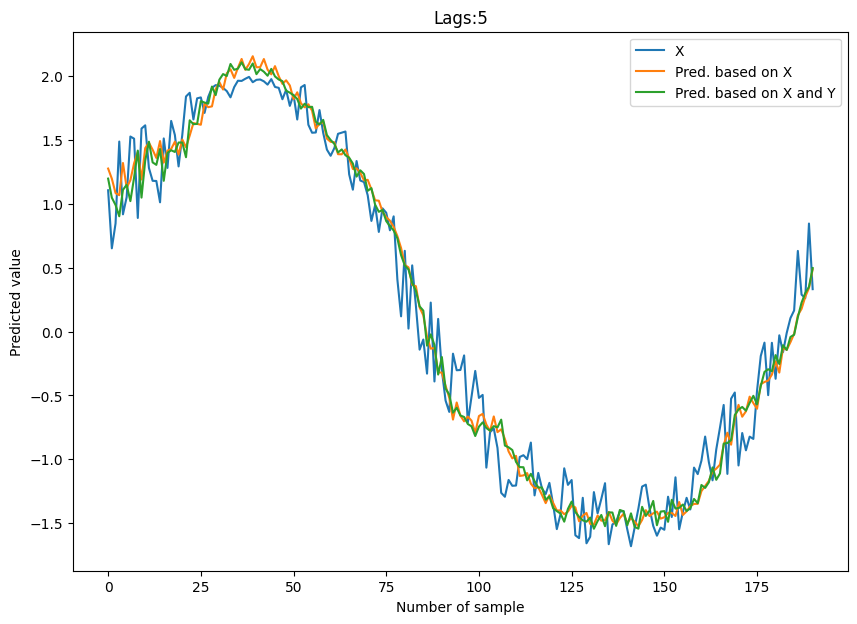

/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statistics value = 8785.0 p-value = 0.013597302548135959


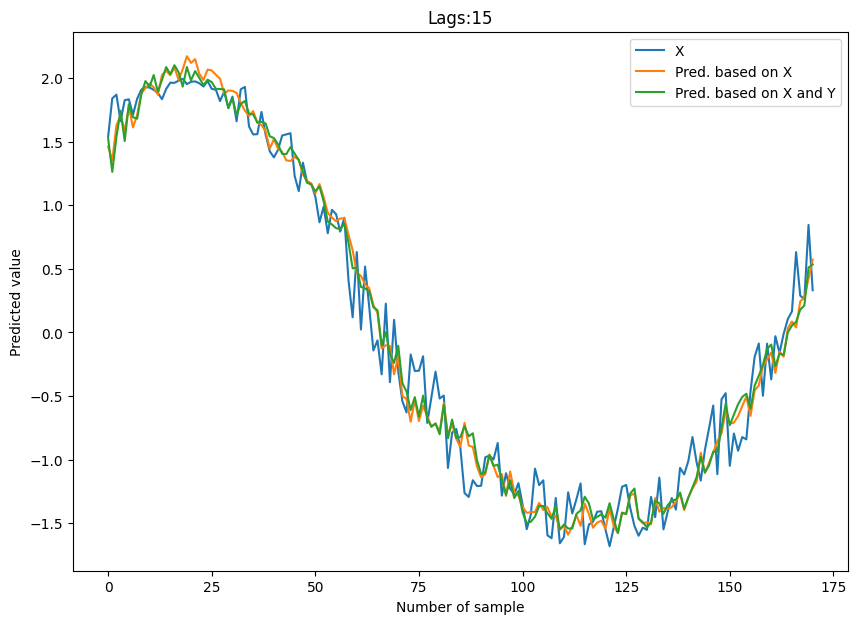

In [ ]:
#%% Example of usage other functions for causality analysis

# ARIMA/ARIMAX models
results_ARIMA = nlc.nonlincausalityARIMA(x=data_train[::10], maxlag=[5,15], x_test=data_test[::10])